In [19]:
# Inputs

# Add filing status and state of residence
filing_status = 'single'  # options: 'single', 'married_filing_jointly', 'head_of_household', etc.
state_of_residence = 'TX'  # Enter your state abbreviation (e.g., 'CA', 'NY', 'TX')
# Add income and 401k, Medical insurance is not deducted here. TODO - Add medical, HSA< FSA etc. 
gross_income = 68000
k401_contrib = 0.10  # 20% contribution (pre-tax traditional 401k)
roth_401k_contrib = 0.10  # 10% Roth 401(k) contribution (combined limit with traditional is $23,500)
# Note: Roth 401(k) contributions are post-tax (after federal & FICA taxes)

In [20]:
# 2026 Tax Year Values (Official IRS Values)
# Source: IRS Revenue Procedure 2025-32 (Released Oct 9, 2025)
# https://www.irs.gov/newsroom/irs-releases-tax-inflation-adjustments-for-tax-year-2026-including-amendments-from-the-one-big-beautiful-bill
# These values include amendments from the "One, Big, Beautiful Bill" (OBBB)

# Adjust standard deduction and tax brackets based on filing status
if filing_status == 'single':
    standard_deduction = 16_100  # 2026 standard deduction, single
    # Tax brackets: (rate, bracket width)
    # 10% on income up to $12,400
    # 12% on income from $12,400 to $50,400
    # 22% on income from $50,400 to $105,700
    # 24% on income from $105,700 to $201,775
    # 32% on income from $201,775 to $256,225
    # 35% on income from $256,225 to $640,600
    # 37% on income over $640,600
    tax_brackets = [
        (0.10, 12_400),
        (0.12, 38_000),   # 50,400 - 12,400
        (0.22, 55_300),   # 105,700 - 50,400
        (0.24, 96_075),   # 201,775 - 105,700
        (0.32, 54_450),   # 256,225 - 201,775
        (0.35, 384_375),  # 640,600 - 256,225
        (0.37, float('inf'))  # Over 640,600
    ]
elif filing_status == 'married_filing_jointly':
    standard_deduction = 32_200  # 2026 standard deduction, married filing jointly
    # 10% on income up to $24,800
    # 12% on income from $24,800 to $100,800
    # 22% on income from $100,800 to $211,400
    # 24% on income from $211,400 to $403,550
    # 32% on income from $403,550 to $512,450
    # 35% on income from $512,450 to $768,700
    # 37% on income over $768,700
    tax_brackets = [
        (0.10, 24_800),
        (0.12, 76_000),   # 100,800 - 24,800
        (0.22, 110_600),  # 211,400 - 100,800
        (0.24, 192_150),  # 403,550 - 211,400
        (0.32, 108_900),  # 512,450 - 403,550
        (0.35, 256_250),  # 768,700 - 512,450
        (0.37, float('inf'))  # Over 768,700
    ]
elif filing_status == 'head_of_household':
    standard_deduction = 24_150  # 2026 standard deduction, head of household
    # Head of household brackets are not explicitly stated in the summary
    # but follow similar pattern between single and married filing jointly
    # These values would need to be verified in Revenue Procedure 2025-32 PDF
    tax_brackets = [
        (0.10, 17_700),   # Estimated based on historical ratios
        (0.12, 49_650),   # Estimated
        (0.22, 79_000),   # Estimated  
        (0.24, 132_250),  # Estimated
        (0.32, 79_350),   # Estimated
        (0.35, 384_375),  # Estimated
        (0.37, float('inf'))
    ]
else:
    raise ValueError('Unsupported filing status')

# Note: State of residence does not affect federal tax, but you can add state tax logic if needed.

In [21]:
# Compute taxable income after pre-tax 401(k) and standard deduction
taxable_income = gross_income * (1 - k401_contrib) - standard_deduction
print(f'taxable_income: {taxable_income}')
k401_amount = gross_income * k401_contrib
print(f'k401_amount: {k401_amount}')

taxable_income: 45100.0
k401_amount: 6800.0


In [22]:
# Compute tax using the brackets
tax = 0
remaining = max(0, taxable_income)  # Ensure non-negative
for rate, cap in tax_brackets:
    if remaining <= 0:
        break
    if remaining > cap:
        tax += rate * cap
        remaining -= cap
    else:
        tax += rate * remaining
        break
print(f'tax: {tax}')

tax: 5164.0


In [23]:
# Calculate FICA (Social Security + Medicare) deductions
# Source: Social Security Administration annual wage base announcements
# 2026 value: Verify at https://www.ssa.gov/news/press/
fica_rate = 0.0765  # 6.2% SS + 1.45% Medicare
ss_rate = 0.062
ss_cap = 176_100  # 2026 Social Security wage base cap (VERIFY with SSA)
medicare_rate = 0.0145

# Social Security deduction (capped)
ss_wages = min(gross_income, ss_cap)
ss_deduction = ss_wages * ss_rate

# Medicare deduction (no cap for most earners)
medicare_deduction = gross_income * medicare_rate

fica_deduction = ss_deduction + medicare_deduction
print(f'Social Security deduction: {ss_deduction}')
print(f'Medicare deduction: {medicare_deduction}')
print(f'Total FICA deduction: {fica_deduction}')

Social Security deduction: 4216.0
Medicare deduction: 986.0
Total FICA deduction: 5202.0


In [31]:
# Final net income and monthly take-home (subtracting FICA deductions and Roth 401k)
roth_401k_annual = gross_income * roth_401k_contrib
net_income_before_roth = gross_income - (gross_income * k401_contrib) - tax - fica_deduction
net_income = net_income_before_roth - roth_401k_annual

# Monthly breakdown
monthly_take_home = net_income / 12
monthly_tax = tax / 12
monthly_401k = (gross_income * k401_contrib) / 12
monthly_roth_401k = roth_401k_annual / 12

print(f'=== Monthly Breakdown ===')
print(f'Monthly Take-Home: ${monthly_take_home:,.2f}')
print(f'Monthly Tax: ${monthly_tax:,.2f}')
print(f'Monthly 401(k) (Traditional): ${monthly_401k:,.2f}')
print(f'Monthly Roth 401(k): ${monthly_roth_401k:,.2f}')
print(f'\n=== Annual Summary ===')
print(f'Annual Net Income (after Roth 401k): ${net_income:,.2f}')

=== Monthly Breakdown ===
Monthly Take-Home: $3,737.50
Monthly Tax: $362.33
Monthly 401(k) (Traditional): $566.67
Monthly Roth 401(k): $566.67

=== Annual Summary ===
Annual Net Income (after Roth 401k): $44,850.00


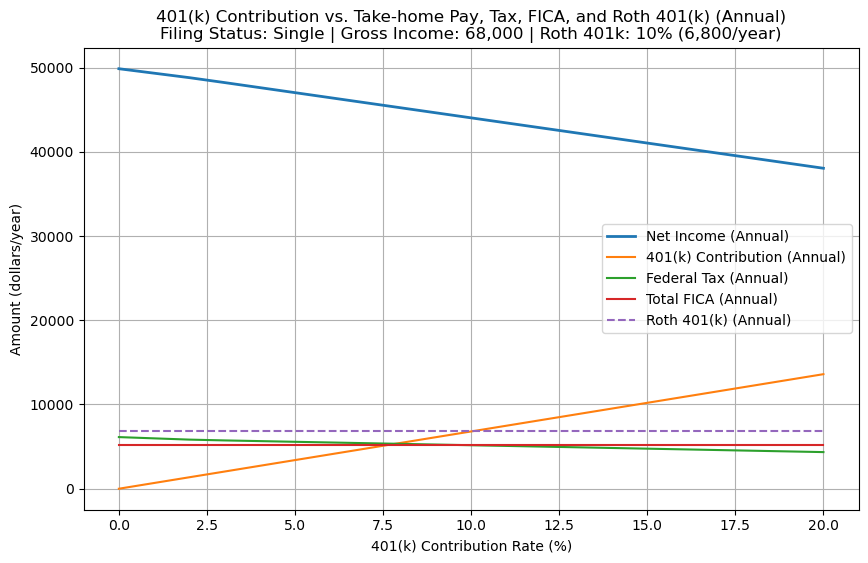

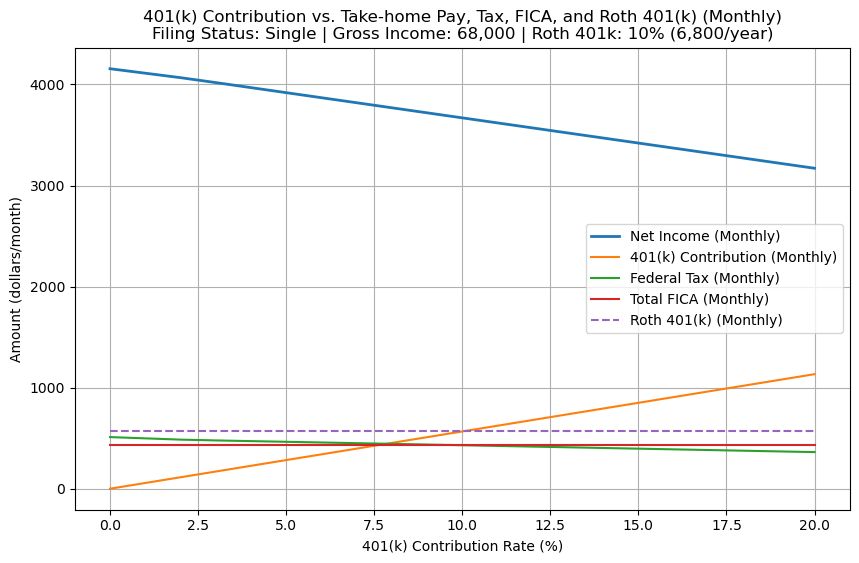

In [33]:
# Prepare both monthly and annual results for plotting (including Roth 401k)
import numpy as np
import matplotlib.pyplot as plt

# Calculate Roth 401k amount for display
roth_401k_annual = gross_income * roth_401k_contrib

# Add details for plot titles and annotations (avoid $ symbols for matplotlib)
plot_details = f"Filing Status: {filing_status.title()} | Gross Income: {gross_income:,.0f} | Roth 401k: {roth_401k_contrib*100:.0f}% ({roth_401k_annual:,.0f}/year)"

results_annual = []
results_monthly = []
contrib_range = np.arange(0, 0.21, 0.01)  # 0% to 20% in 1% steps
for contrib in contrib_range:
    k401_amount = gross_income * contrib
    roth_401k_amount = gross_income * roth_401k_contrib
    taxable_income = gross_income * (1 - contrib) - standard_deduction
    # Compute tax
    tax = 0
    remaining = max(0, taxable_income)  # Ensure non-negative
    for rate, cap in tax_brackets:
        if remaining <= 0:
            break
        if remaining > cap:
            tax += rate * cap
            remaining -= cap
        else:
            tax += rate * remaining
            break
    # FICA deductions
    ss_wages = min(gross_income, ss_cap)
    ss_deduction = ss_wages * ss_rate
    medicare_deduction = gross_income * medicare_rate
    fica_deduction = ss_deduction + medicare_deduction
    # Net income (including Roth 401k)
    net_income_before_roth = gross_income - k401_amount - tax - fica_deduction
    net_income = net_income_before_roth - roth_401k_amount
    monthly_take_home = net_income / 12
    monthly_k401 = k401_amount / 12
    monthly_tax = tax / 12
    monthly_fica = fica_deduction / 12
    monthly_roth = roth_401k_amount / 12
    results_annual.append((contrib, k401_amount, tax, net_income, fica_deduction, roth_401k_amount))
    results_monthly.append((contrib, monthly_k401, monthly_tax, monthly_take_home, monthly_fica, monthly_roth))

results_annual = np.array(results_annual)
results_monthly = np.array(results_monthly)

# Plot annual numbers
plt.figure(figsize=(10,6))
plt.plot(results_annual[:,0]*100, results_annual[:,3], label='Net Income (Annual)', linewidth=2)
plt.plot(results_annual[:,0]*100, results_annual[:,1], label='401(k) Contribution (Annual)')
plt.plot(results_annual[:,0]*100, results_annual[:,2], label='Federal Tax (Annual)')
plt.plot(results_annual[:,0]*100, results_annual[:,4], label='Total FICA (Annual)')
plt.plot(results_annual[:,0]*100, results_annual[:,5], label='Roth 401(k) (Annual)', linestyle='--')
plt.xlabel('401(k) Contribution Rate (%)')
plt.ylabel('Amount (dollars/year)')
plt.title('401(k) Contribution vs. Take-home Pay, Tax, FICA, and Roth 401(k) (Annual)\n' + plot_details, usetex=False)
plt.legend()
plt.grid(True)
plt.show()

# Plot monthly numbers
plt.figure(figsize=(10,6))
plt.plot(results_monthly[:,0]*100, results_monthly[:,3], label='Net Income (Monthly)', linewidth=2)
plt.plot(results_monthly[:,0]*100, results_monthly[:,1], label='401(k) Contribution (Monthly)')
plt.plot(results_monthly[:,0]*100, results_monthly[:,2], label='Federal Tax (Monthly)')
plt.plot(results_monthly[:,0]*100, results_monthly[:,4], label='Total FICA (Monthly)')
plt.plot(results_monthly[:,0]*100, results_monthly[:,5], label='Roth 401(k) (Monthly)', linestyle='--')
plt.xlabel('401(k) Contribution Rate (%)')
plt.ylabel('Amount (dollars/month)')
plt.title('401(k) Contribution vs. Take-home Pay, Tax, FICA, and Roth 401(k) (Monthly)\n' + plot_details, usetex=False)
plt.legend()
plt.grid(True)
plt.show()


In [26]:
# Interactive ECharts plots for 401(k) optimization (annual and monthly amounts, including FICA and Roth 401k)
import json
from IPython.display import display, HTML

# Prepare data for ECharts (annual and monthly amounts, including FICA and Roth 401k)
echarts_data_annual = {
    'contrib_rate': (results_annual[:,0]*100).tolist(),
    'annual_take_home': results_annual[:,3].tolist(),
    'annual_k401': results_annual[:,1].tolist(),
    'annual_tax': results_annual[:,2].tolist(),
    'annual_fica': results_annual[:,4].tolist(),
    'annual_roth': results_annual[:,5].tolist()
}
echarts_data_monthly = {
    'contrib_rate': (results_monthly[:,0]*100).tolist(),
    'monthly_take_home': results_monthly[:,3].tolist(),
    'monthly_k401': results_monthly[:,1].tolist(),
    'monthly_tax': results_monthly[:,2].tolist(),
    'monthly_fica': results_monthly[:,4].tolist(),
    'monthly_roth': results_monthly[:,5].tolist()
}

# Add details for ECharts titles
roth_401k_annual = gross_income * roth_401k_contrib
echarts_plot_details = f"Filing Status: {filing_status.title()} | Gross Income: ${gross_income:,.0f} | Roth 401k: {roth_401k_contrib*100:.0f}% (${roth_401k_annual:,.0f}/year)"

# Annual ECharts config
echarts_config_annual = {
    'title': {
        'text': f"401(k) Contribution vs. Take-home Pay, Tax, FICA, and Roth 401(k) (Annual) | {echarts_plot_details}",
        'left': 'center'
    },
    'tooltip': {
        'trigger': 'axis',
        'axisPointer': { 'type': 'cross' }
    },
    'legend': {
        'data': ['Net Income (Annual)', '401(k) Contribution (Annual)', 'Federal Tax (Annual)', 'Total FICA (Annual)', 'Roth 401(k) (Annual)'],
        'top': 30
    },
    'toolbox': {
        'feature': {
            'saveAsImage': {}
        }
    },
    'xAxis': {
        'type': 'category',
        'name': '401(k) Contribution Rate (%)',
        'data': echarts_data_annual['contrib_rate']
    },
    'yAxis': {
        'type': 'value',
        'name': 'Amount ($/year)'
    },
    'series': [
        {
            'name': 'Net Income (Annual)',
            'type': 'line',
            'data': echarts_data_annual['annual_take_home'],
            'smooth': True,
            'lineStyle': {'width': 3}
        },
        {
            'name': '401(k) Contribution (Annual)',
            'type': 'line',
            'data': echarts_data_annual['annual_k401'],
            'smooth': True
        },
        {
            'name': 'Federal Tax (Annual)',
            'type': 'line',
            'data': echarts_data_annual['annual_tax'],
            'smooth': True
        },
        {
            'name': 'Total FICA (Annual)',
            'type': 'line',
            'data': echarts_data_annual['annual_fica'],
            'smooth': True
        },
        {
            'name': 'Roth 401(k) (Annual)',
            'type': 'line',
            'data': echarts_data_annual['annual_roth'],
            'smooth': True,
            'lineStyle': {'type': 'dashed'}
        }
    ]
}

# Monthly ECharts config
echarts_config_monthly = {
    'title': {
        'text': f"401(k) Contribution vs. Take-home Pay, Tax, FICA, and Roth 401(k) (Monthly) | {echarts_plot_details}",
        'left': 'center'
    },
    'tooltip': {
        'trigger': 'axis',
        'axisPointer': { 'type': 'cross' }
    },
    'legend': {
        'data': ['Net Income (Monthly)', '401(k) Contribution (Monthly)', 'Federal Tax (Monthly)', 'Total FICA (Monthly)', 'Roth 401(k) (Monthly)'],
        'top': 30
    },
    'toolbox': {
        'feature': {
            'saveAsImage': {}
        }
    },
    'xAxis': {
        'type': 'category',
        'name': '401(k) Contribution Rate (%)',
        'data': echarts_data_monthly['contrib_rate']
    },
    'yAxis': {
        'type': 'value',
        'name': 'Amount ($/month)'
    },
    'series': [
        {
            'name': 'Net Income (Monthly)',
            'type': 'line',
            'data': echarts_data_monthly['monthly_take_home'],
            'smooth': True,
            'lineStyle': {'width': 3}
        },
        {
            'name': '401(k) Contribution (Monthly)',
            'type': 'line',
            'data': echarts_data_monthly['monthly_k401'],
            'smooth': True
        },
        {
            'name': 'Federal Tax (Monthly)',
            'type': 'line',
            'data': echarts_data_monthly['monthly_tax'],
            'smooth': True
        },
        {
            'name': 'Total FICA (Monthly)',
            'type': 'line',
            'data': echarts_data_monthly['monthly_fica'],
            'smooth': True
        },
        {
            'name': 'Roth 401(k) (Monthly)',
            'type': 'line',
            'data': echarts_data_monthly['monthly_roth'],
            'smooth': True,
            'lineStyle': {'type': 'dashed'}
        }
    ]
}

# Display both ECharts plots in notebook (if desired, or just export as HTML as before)

In [27]:
# Display interactive ECharts plots inline (works in Binder and local notebooks)
from IPython.display import HTML, FileLink, display
import webbrowser
import os

roth_401k_annual = gross_income * roth_401k_contrib
echarts_html_file = '401k_optimization_echarts_annual_monthly.html'
standalone_html = f'''
<!DOCTYPE html>
<html>
<head>
    <meta charset="utf-8">
    <title>401(k) & Roth 401(k) Contribution Optimization (Annual & Monthly)</title>
    <script src="https://cdn.jsdelivr.net/npm/echarts@5/dist/echarts.min.js"></script>
</head>
<body>
    <div id="echarts_opt_annual" style="width: 100%; height: 400px;"></div>
    <div id="echarts_opt_monthly" style="width: 100%; height: 400px; margin-top: 30px;"></div>
    <script>
    var chartDomA = document.getElementById('echarts_opt_annual');
    var myChartA = echarts.init(chartDomA);
    var optionA = {json.dumps(echarts_config_annual)};
    var chartDomM = document.getElementById('echarts_opt_monthly');
    var myChartM = echarts.init(chartDomM);
    var optionM = {json.dumps(echarts_config_monthly)};
    myChartA.setOption(optionA);
    myChartM.setOption(optionM);
    // Link axis pointers and tooltips
    myChartA.group = 'echarts_linked';
    myChartM.group = 'echarts_linked';
    echarts.connect('echarts_linked');
    </script>
    <div style="margin-top:20px; font-size:1.1em; color:#333;">
        <b>Filing Status:</b> {filing_status.title()} &nbsp; | &nbsp; 
        <b>Gross Income:</b> ${gross_income:,.0f} &nbsp; | &nbsp; 
        <b>Roth 401(k):</b> {roth_401k_contrib*100:.0f}% (${roth_401k_annual:,.0f}/year)
    </div>
</body>
</html>
'''

# Save HTML file for download
with open(echarts_html_file, 'w', encoding='utf-8') as f:
    f.write(standalone_html)

print(f'✓ ECharts HTML file saved as: {echarts_html_file}')

# Display charts inline in notebook (works in Jupyter and Binder)
print('\nInteractive charts displayed below:')
display(HTML(standalone_html))

# Provide download link (especially useful in Binder)
print('\nDownload standalone HTML file:')
display(FileLink(echarts_html_file))

# Open in browser if running locally (will be ignored in Binder)
try:
    if os.environ.get('JUPYTERHUB_USER') is None:  # Not in Binder/JupyterHub
        webbrowser.open(echarts_html_file)
except:
    pass

✓ ECharts HTML file saved as: 401k_optimization_echarts_annual_monthly.html

Interactive charts displayed below:



Download standalone HTML file:


c:\_COE\Sandbox\2026Tax\401k_optimization_echarts_annual_monthly.html